# Init

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [2]:
import urllib.request  # lib that handles URLs
import io
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

import pyspark.sql.functions as func

# Get GDELT Schema

In [3]:
target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data))
colnames_events = list(formats["tableId"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_eventMentions_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_mentions = list(formats.loc[:15,"0"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_gdeltKnowledgeGraph_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_gkg = list(formats["tableId"])

# Dataset Imports

In [4]:
start = datetime.now()

df_events = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/events/2017*.export.csv",
                "s3://gdelt-open-data/v2/events/2018*.export.csv"])
df_events = df_events.toDF(*colnames_events)
df_events.cache()

print(df_events.count())
print(df_events.printSchema())
print(datetime.now()-start)

127869166
root
 |-- GLOBALEVENTID: integer (nullable = true)
 |-- SQLDATE: integer (nullable = true)
 |-- MonthYear: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- FractionDate: double (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor1KnownGroupCode: string (nullable = true)
 |-- Actor1EthnicCode: string (nullable = true)
 |-- Actor1Religion1Code: string (nullable = true)
 |-- Actor1Religion2Code: string (nullable = true)
 |-- Actor1Type1Code: string (nullable = true)
 |-- Actor1Type2Code: string (nullable = true)
 |-- Actor1Type3Code: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- Actor2KnownGroupCode: string (nullable = true)
 |-- Actor2EthnicCode: string (nullable = true)
 |-- Actor2Religion1Code: string (nullable = true)
 |-- Actor2Relig

In [5]:
start = datetime.now()

df_mentions = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/mentions/2017*.mentions.csv",
                "s3://gdelt-open-data/v2/mentions/2018*.mentions.csv"]) \
    .select(["_c1","_c4","_c5","_c13"]).distinct()
df_mentions = df_mentions.toDF(*["MentionSource","MentionIdentifier","MentionDocTone"])
df_mentions.cache()

print(df_mentions.count())
print(df_mentions.printSchema())
print(datetime.now()-start)

71854229
root
 |-- MentionSource: string (nullable = true)
 |-- MentionIdentifier: string (nullable = true)
 |-- MentionDocTone: string (nullable = true)

None
0:14:00.095888


# Basic Plots

### Plotting functions

In [66]:
def plot_line_over_time(x,y_dict,y_axis_label,filename):
    fig, ax = plt.subplots(figsize=(10,5))

    data_to_plot = list(y_dict.items())
    
    # first set of data
    ax.plot(x,data_to_plot[0][1],label=data_to_plot[0][0])
    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.set_ylabel(y_axis_label)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.legend()
    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def plot_line_over_time_two_y_axis(x,y_dict,filename):
    fig, ax = plt.subplots(figsize=(10,5))

    data_to_plot = list(y_dict.items())
    
    # first set of data
    ax.plot(x,data_to_plot[0][1],label=data_to_plot[0][0])
    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.set_ylabel(data_to_plot[0][0])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if len(data_to_plot) > 1:
        for i in range(1,len(data_to_plot)):
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
            ax2.set_ylabel(data_to_plot[i][0])
            ax2.plot(x,data_to_plot[i][1],data_to_plot[i][1])      

    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def counts_by_week_year(relevant_events):
    # group by day
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").count().collect())
    all_events_by_day.columns = ["Date","Count"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["Count"].sum().reset_index()

    return all_events_by_day


def avg_tone_by_week_year(relevant_events):
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").agg(func.mean("AvgTone").alias("AvgTone")).collect())
    all_events_by_day.columns = ["Date","AvgTone"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["AvgTone"].mean().reset_index()

    return all_events_by_day


### Plot Count of All Events by Day

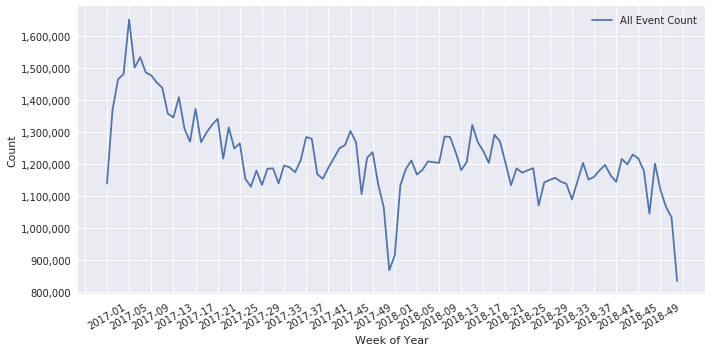

In [62]:
# group by week_year
data = counts_by_week_year(df_events)

# group by week and plot
x=data["YearWeek"]
y_dict = {}
y_dict["All Event Count"] = data["Count"]
plot_line_over_time(x,y_dict,"Count","All_Events_Counts")

### Plot trump mentions

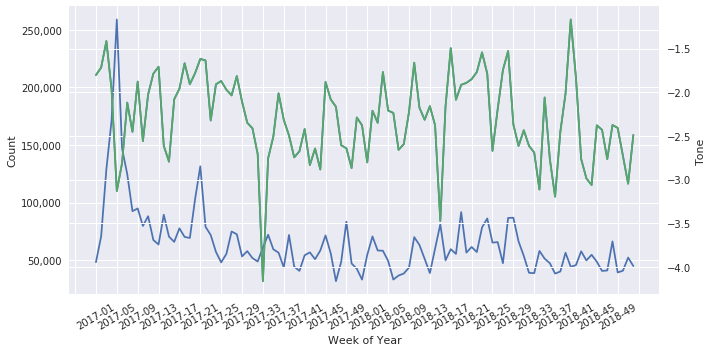

In [67]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))

# group by week_year
counts = counts_by_week_year(relevant_events)
tone = avg_tone_by_week_year(relevant_events)

# plot
x=counts["YearWeek"]
y_dict = {}
y_dict["Count"] = counts["Count"]
y_dict["Tone"]=tone["AvgTone"]

plot_line_over_time_two_y_axis(x,y_dict,"Trump_Events_Counts")

### Plot tariff mentions

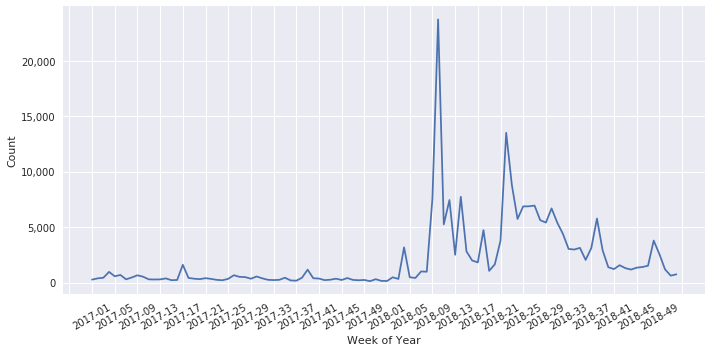

In [54]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y_dict = {}
y_dict["Count"] = data["Count"]
plot_line_over_time(x,y_dict,"Tariff_Events_Counts")

# EDA Across Fields
We could show how many countries are represented by the dataset.  Might just be interesting to show the breadth of the data.

# Write Data to Parquet Format

In [13]:
df_events.write.parquet("s3://labadie-gdelt-tradewar/events.parquet", mode="overwrite")

In [15]:
df_mentions.write.parquet("s3://labadie-gdelt-tradewar/mentions.parquet", mode="overwrite")